In [1]:
# This script is based on:
# https://www.tensorflow.org/get_started/mnist/pros

import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import graph_util as gu
from tensorflow.python.framework.graph_util import remove_training_nodes
from tensorflow.tools.graph_transforms import TransformGraph
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Load the test data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [104]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

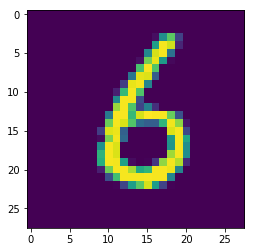

In [109]:
plt.imshow(mnist.train.images[9,].reshape(28, 28))
plt.show()

In [112]:
image_tmp, label_tmp = datagen.flow(mnist.train.images[9,].reshape(1, 28, 28, 1), 
                                    mnist.train.labels[9,].reshape(1, 10)).next()

In [116]:
image_tmp.shape

(1, 28, 28, 1)

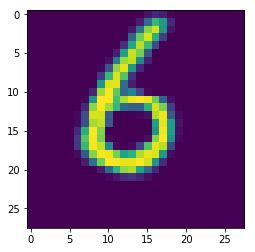

In [117]:
plt.imshow(image_tmp.reshape(28, 28))
plt.show()

### TF model

In [32]:
tf.reset_default_graph()

In [33]:
img_size, num_channels, num_classes = 28, 1, 10
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_')

In [34]:
W_conv1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 16], stddev=5e-2))
b_conv1 = tf.Variable(tf.constant(0.001, shape=[16]))
conv1 = tf.nn.conv2d(x, W_conv1, [1, 1, 1, 1], padding='SAME', name='conv1')
h_conv1 = tf.nn.relu(tf.add(conv1, b_conv1), name='h_conv1')
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')
drop1 = tf.nn.dropout(h_pool1, keep_prob=0.9)
print(drop1)

Tensor("dropout/mul:0", shape=(?, 14, 14, 16), dtype=float32)


In [35]:
W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 16, 32], stddev=5e-2))
b_conv2 = tf.Variable(tf.constant(0.01, shape=[32]))
conv2 = tf.nn.conv2d(drop1, W_conv2, [1, 1, 1, 1], padding='SAME', name='conv2')
h_conv2 = tf.nn.relu(tf.add(conv2, b_conv2), name='h_conv2')
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')
drop2 = tf.nn.dropout(h_pool2, keep_prob=0.75)
print(drop2)

Tensor("dropout_1/mul:0", shape=(?, 7, 7, 32), dtype=float32)


In [36]:
W_conv3 = tf.Variable(tf.truncated_normal(shape=[5, 5, 32, 64], stddev=5e-2))
b_conv3 = tf.Variable(tf.constant(0.1, shape=[64]))
conv3 = tf.nn.conv2d(input=drop2, filter=W_conv3, strides=[1, 1, 1, 1], padding='SAME', name='conv3')
h_conv3 = tf.nn.relu(tf.add(conv3, b_conv3), name='h_conv3')
h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')
drop3 = tf.nn.dropout(h_pool3, keep_prob=0.75)
print(drop3)

Tensor("dropout_2/mul:0", shape=(?, 4, 4, 64), dtype=float32)


In [37]:
drop3_flat = tf.reshape(drop3, [-1, 4 * 4 * 64])
print(drop3_flat)

Tensor("Reshape:0", shape=(?, 1024), dtype=float32)


In [38]:
W_fc1 = tf.Variable(tf.truncated_normal([4 * 4 * 64, 128], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[128]))
h_fc1 = tf.nn.relu(tf.add(tf.matmul(drop3_flat, W_fc1), b_fc1), name='fc1')
drop4 = tf.nn.dropout(h_fc1, keep_prob=0.5)
print(drop4)

Tensor("dropout_3/mul:0", shape=(?, 128), dtype=float32)


In [39]:
W_fc2 = tf.Variable(tf.truncated_normal([128, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
logits = tf.add(tf.matmul(drop4, W_fc2), b_fc2, name='logits')
y_pred = tf.argmax(logits, axis=1, name='y_pred')

In [40]:
with tf.name_scope("Loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, 
                                                               logits=logits)
    loss = tf.reduce_mean(cross_entropy, name="cross_entropy_loss")
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss, name="train_step")
  
# Here we specify the output as "Prediction/y_pred", this will be important later
with tf.name_scope("Prediction"): 
    correct_prediction = tf.equal(y_pred, 
                                  tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [41]:
batch_size = 20
n_epochs = 20
n_batches = int(mnist.train.num_examples / batch_size)
print(n_batches)

2750


In [42]:
sess = tf.Session()
# Initialize the variables (i.e. assign their default value)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

train_loss, train_accuracy = sess.run([loss, accuracy], 
                                      feed_dict={x: mnist.train.images.reshape(mnist.train.num_examples, img_size, img_size, num_channels), 
                                                 y_: mnist.train.labels})
print('Epoch %d, training loss: %g, training accuracy: %g' % (0, train_loss, train_accuracy))
val_loss, val_accuracy = sess.run([loss, accuracy], 
                                  feed_dict={x: mnist.validation.images.reshape(mnist.validation.num_examples, img_size, img_size, num_channels),
                                             y_: mnist.validation.labels})
print('Epoch %d, validation loss: %g, validation accuracy %g' % (0, val_loss, val_accuracy))

Epoch 0, training loss: 2.45862, training accuracy: 0.0977455
Epoch 0, validation loss: 2.44247, validation accuracy 0.0996


In [45]:
for i in range(n_epochs):
    for j in range(n_batches):
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_images.reshape(batch_size, img_size, img_size, num_channels), 
                                        y_: batch_labels})
        
    if i % 5 == 0:
        train_loss, train_accuracy = sess.run([loss, accuracy], 
                                              feed_dict={x: mnist.train.images.reshape(mnist.train.num_examples, img_size, img_size, num_channels), 
                                                         y_: mnist.train.labels})
        print('Epoch %d, training loss: %g, training accuracy: %g' % (i, train_loss, train_accuracy))
        val_loss, val_accuracy = sess.run([loss, accuracy], 
                                          feed_dict={x: mnist.validation.images.reshape(mnist.validation.num_examples, img_size, img_size, num_channels),
                                                     y_: mnist.validation.labels})
        print('Epoch %d, validation loss: %g, validation accuracy %g' % (i, val_loss, val_accuracy))

Epoch 0, training loss: 0.0188238, training accuracy: 0.994018
Epoch 0, validation loss: 0.0359904, validation accuracy 0.9904
Epoch 5, training loss: 0.0168554, training accuracy: 0.994782
Epoch 5, validation loss: 0.0403755, validation accuracy 0.99
Epoch 10, training loss: 0.016046, training accuracy: 0.994764
Epoch 10, validation loss: 0.0370405, validation accuracy 0.9906
Epoch 15, training loss: 0.0134388, training accuracy: 0.995491
Epoch 15, validation loss: 0.0389939, validation accuracy 0.9916


In [46]:
print('test accuracy %g' % sess.run(accuracy, 
                                    feed_dict={x: mnist.validation.images.reshape(mnist.validation.num_examples, img_size, img_size, num_channels), 
                                               y_: mnist.validation.labels}))

test accuracy 0.989


In [47]:
print('test accuracy %g' % sess.run(accuracy, 
                                    feed_dict={x: mnist.test.images.reshape(mnist.test.num_examples, img_size, img_size, num_channels), 
                                               y_: mnist.test.labels}))

test accuracy 0.9893


In [48]:
saver.save(sess, "./chkps/mnist_cnn")
out_nodes = [y_pred.op.name]
print(out_nodes)

['y_pred']


In [49]:
sub_graph_def = remove_training_nodes(sess.graph_def)

In [50]:
sub_graph_def = gu.convert_variables_to_constants(sess, sub_graph_def, out_nodes)

INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [51]:
graph_path = tf.train.write_graph(sub_graph_def,
                                  "./mnist_cnn_0to9",
                                  "mnist_cnn.pb",
                                  as_text=False)

print('written graph to: %s' % graph_path)

written graph to: ./mnist_cnn_0to9/mnist_cnn.pb


In [52]:
sess.run(y_pred, feed_dict={x: mnist.test.images[[3, 2, 1, 18, 4, 15, 11, 0, 61, 7], :].reshape(10, 28, 28, 1)})

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [53]:
sess.close()